### Machine Learning (C24), Spring 2024, Project Group F
-----
# Linear Regression Models
This notebook fits linear regression models for the dataset at **df_clean.csv** and outputs a comparative data table of common regression (y-num) metrics.

Data
- y = `'price actual'`
- X = weather features from five cities, national energy data

Models fitted (scikit-learn):
-  `DummyRegressor` (baseline metrics)
1. `LinearRegression`
2. `Ridge`
3. `Lasso`

Evaluation metrics:
1. MSE, RMSE, R^2, MAE, MAPE table
2. Plots
3. Feature importance

In [1]:
# Import libraries
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split, cross_val_score, KFold
#from sklearn.pipeline import make_pipeline

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import project functions
import sys
sys.path.append('../')
from functions import prep_split, add_model_eval, model_eval_plot, regression_coef_plot

## Data Preparation

Steps:
1. Drop unneeded columns
2. Split X/y, train/test
3. Standardize X

Considerations:
- X
    - include electricity "features"?
    - OHE weather dummy variables?
    - try weighted average of five cities
- y: standardize or NOT?
- CV: normal or time-informed CV?

Note conventions
- 0: training data
- 1: test data

In [2]:
df = pd.read_csv('../Data/df_clean.csv', index_col="time", parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

In [3]:
# 1. Drop 'price*' from X by default
price_cols = [col for col in df.columns if 'price' in col]
#generation_cols = [col for col in df.columns if 'generation' in col or 'forecast' in col or 'load' in col]
#generation_cols = [col for col in df.columns if 'generation' in col]
#weather_cols = [col for col in df.columns if 'weather' in col]

In [4]:
# 2/3. "prep_split" includes dropping specified columns, then standardizing all remaining X (but not y)
X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=price_cols, 
                                               #columns_drop = price_cols + generation_cols + weather_cols,
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=0)

#X_train.describe() #all vars have mean~0, std~1
#y_train.describe() #not standardized

In [5]:
# Setup model evaluation dictionary
model_eval = dict()

## 0. Baseline Dummy
- Uses scikit-learn `DummyRegressor`

In [6]:
# Baseline "dummy" prediction based on y0 mean
#y_pred_dummy = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)

# Calculate Test MSE etc.
model_eval0 = add_model_eval(model_eval, 'dummy_y0_mean', y_test, y_pred_dummy)
pd.DataFrame(model_eval0).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.00324,14.28297,-0.368643,11.953448,0.212781


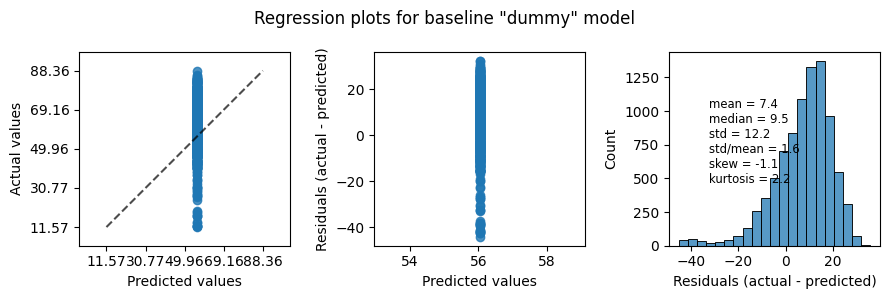

In [7]:
# Key regression plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_dummy, fig, axes, 'Regression plots for baseline "dummy" model')

## 1. Ordinary Least Squares

In [8]:
ols_model = LinearRegression() # 1. Create model
ols_model.fit(X_train, y_train) # 2. Fit model with training data
y_pred_ols = ols_model.predict(X_test) # 3. Use model to predict test data

In [9]:
# 4a. Evaluate
model_eval1 = add_model_eval(model_eval0, 'Linear Regression (OLS)', y_test, y_pred_ols)
pd.DataFrame(model_eval1).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.00324,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS),148.26987,12.176612,0.005268,10.138270,0.168355


In [10]:
# 4a. Check MSE-train vs. MSE-test
mean_squared_error(y_train, ols_model.predict(X_train))

90.08630421312505

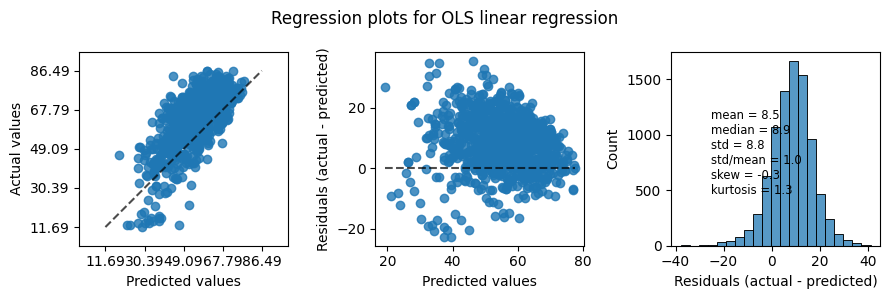

In [11]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ols, fig, axes, 'Regression plots for OLS linear regression')

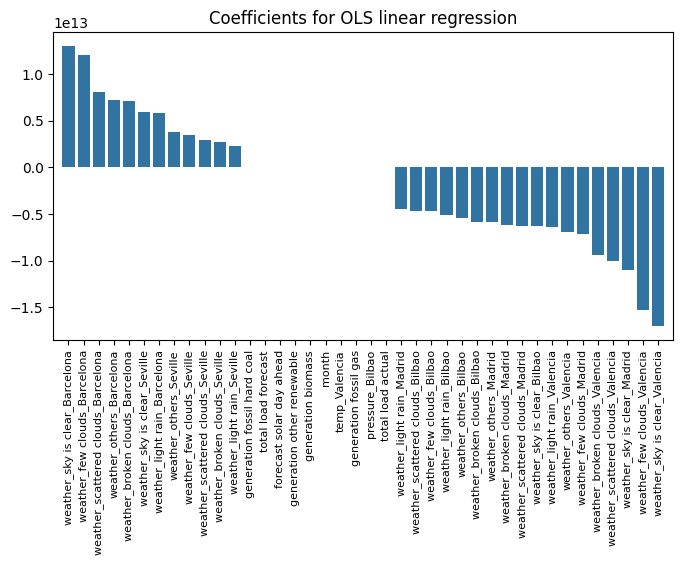

In [12]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(ols_model, fig, axes, 2, 'Coefficients for OLS linear regression')

## 2. Ridge Regression

In [13]:
# Auto-CV
alphas = np.logspace(-5, 5, 20)
ridge_model = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_model.fit(X_train, y_train) 
y_pred_ridge = ridge_model.predict(X_test)
print(f'Best ridge alpha is: {ridge_model.alpha_} with MSE of {ridge_model.best_score_}')

Best ridge alpha is: 29763.51441631313 with MSE of -157.6105802677003


In [14]:
# Manual looping
#ridge_eval = {'alpha': [], 'mse': []}
#for alpha in np.logspace(-4, 4, 20):
#    ridge_model = Ridge(alpha=alpha) # 1. Create model
#    ridge_model.fit(X_train, y_train)  # 2. Fit model with training data
#    y_pred_ridge = ridge_model.predict(X_test)  # 3. Use model to predict test data
#    mse = mean_squared_error(y_test, y_pred_ridge)  # Calculate MSE
#    
#    ridge_eval['alpha'].append(alpha) # Store alpha
#    ridge_eval['mse'].append(mse) # Store MSE
#
#df_ridge_eval = pd.DataFrame(ridge_eval)
#sns.lineplot(data=df_ridge_eval, x='alpha', y='mse')

In [15]:
# 4a. Evaluate
model_eval2 = add_model_eval(model_eval1, 'Ridge Regression', y_test, y_pred_ridge)
pd.DataFrame(model_eval2).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS),148.269870,12.176612,0.005268,10.138270,0.168355
Ridge Regression,169.114842,13.004416,-0.134579,11.090576,0.183115


In [16]:
# 4a. Check MSE-train vs. MSE-test
mean_squared_error(y_train, ridge_model.predict(X_train))

104.68392641425903

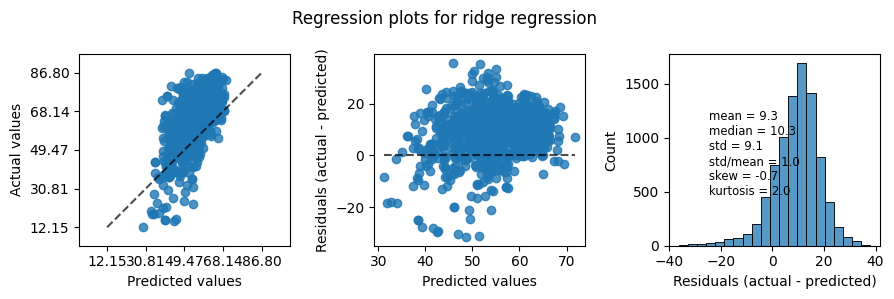

In [17]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ridge, fig, axes, 'Regression plots for ridge regression')

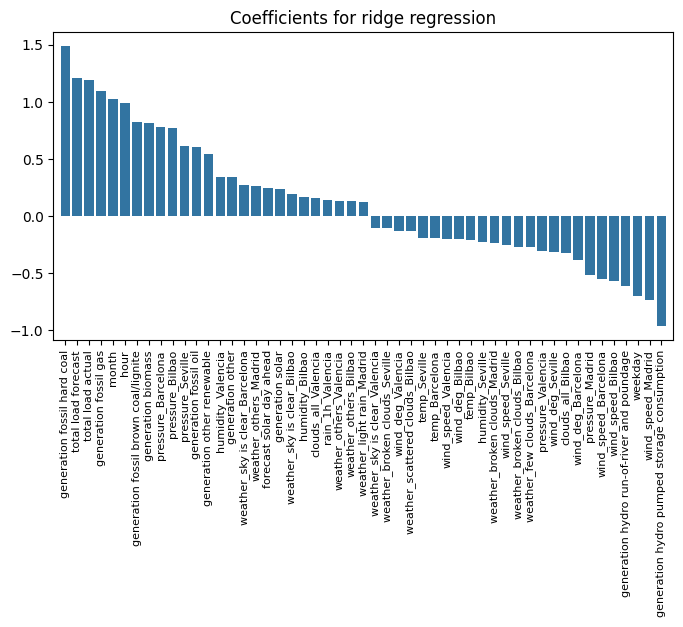

In [18]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(ridge_model, fig, axes, 0.1, 'Coefficients for ridge regression')

## 3. Lasso Regression

In [19]:
# Auto-CV
alphas = np.logspace(-5, 5, 20)
lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train, y_train) 
y_pred_lasso = lasso_model.predict(X_test)
print(f'Best lasso alpha is: {lasso_model.alpha_}')

Best lasso alpha is: 1.8329807108324339


In [20]:
# 4a. Evaluate
model_eval3 = add_model_eval(model_eval2, 'Lasso Regression', y_test, y_pred_lasso)
pd.DataFrame(model_eval3).T

,MSE,RMSE,R2,MAE,MAPE
dummy_y0_mean,204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS),148.269870,12.176612,0.005268,10.138270,0.168355
Ridge Regression,169.114842,13.004416,-0.134579,11.090576,0.183115
Lasso Regression,173.694579,13.179324,-0.165304,11.169163,0.188904


In [21]:
# 4a. Check MSE-train vs. MSE-test
mean_squared_error(y_train, lasso_model.predict(X_train))

124.91563114981793

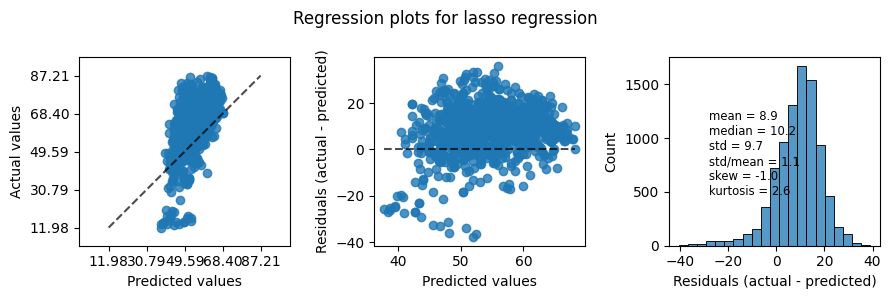

In [22]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_lasso, fig, axes, 'Regression plots for lasso regression')

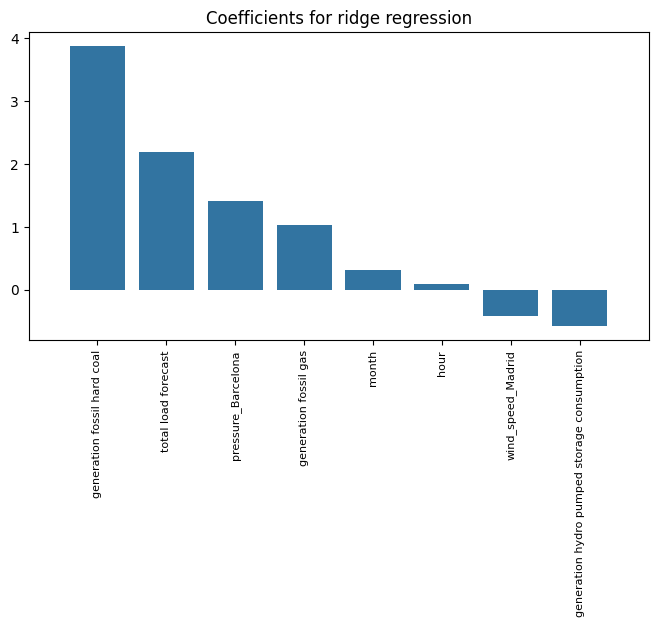

In [23]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(lasso_model, fig, axes, 1e-10, 'Coefficients for ridge regression')